# CNN for AED with Keras/TensorFlow (restaurant)

Date: Nov 19, 2018

Speech recognition with Keras/TensorFlow

Data acquisition: living room

Feature set: MFCCs

## Preparing data set for CNN

In [76]:
DATA_FOLDER = '../oscilloscope/data_restaurant/'

FILTERS=40
FILES = 30
TRAINING_FILES = 20
TEST_FILES = FILES - TRAINING_FILES

In [77]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import os
import sklearn.preprocessing as pp

In [78]:
import glob

#data_files = glob.glob(DATA_FOLDER+'*mel_spectrogram*.csv')
data_files = glob.glob(DATA_FOLDER+'*mfcc*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
#    files = glob.glob(DATA_FOLDER+'{}-*mel_spectrogram*.csv'.format(label))
    files = glob.glob(DATA_FOLDER+'{}-*mfcc*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

LENGTH=96

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[:FILTERS*LENGTH]['magnitude'].values)
        training_set.append((img1, class_number))
    files = v[1]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[:FILTERS*LENGTH]['magnitude'].values)
        test_set.append((img1, class_number))

random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k ))
    class_labels[v[2]] = k

import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

len(training_set), class_labels

0: umai
3: oishii
1: others
2: mazui


(80, ['umai', 'others', 'mazui', 'oishii'])

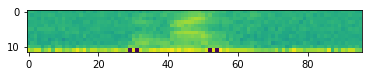

In [79]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data, dtype='float32').reshape((TRAINING_FILES*len(class_labels), LENGTH, FILTERS, 1))
train_data = train_data[:,:,:12,:]

train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data, dtype='float32').reshape((TEST_FILES*len(class_labels), LENGTH, FILTERS, 1))
test_data = test_data[:,:,:12,:]

test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(np.rot90(train_data[20 ,:,:,0]))

### CNN model

In [80]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(LENGTH, 12, 1)))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 94, 10, 8)         80        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 47, 10, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 45, 8, 16)         1168      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 8, 16)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 6, 32)         4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 6, 32)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 4, 64)          18496     
__________

In [81]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

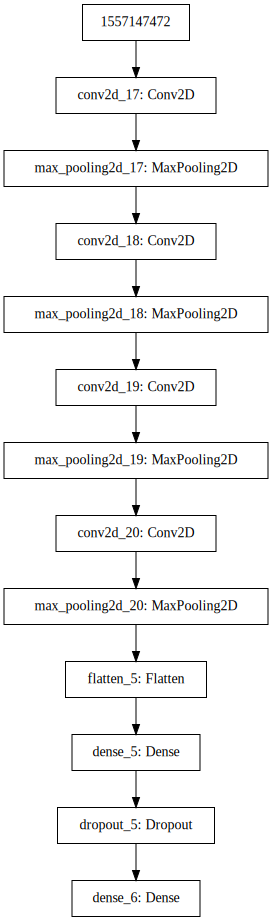

In [82]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [83]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels), batch_size=10)

Train on 80 samples, validate on 40 samples
Epoch 1/30
80/80 [==============================] - 5s 69ms/step - loss: 1.4117 - acc: 0.2250 - val_loss: 1.3612 - val_acc: 0.3750
Epoch 2/30
80/80 [==============================] - 1s 12ms/step - loss: 1.3733 - acc: 0.2750 - val_loss: 1.3090 - val_acc: 0.5500
Epoch 3/30
80/80 [==============================] - 1s 12ms/step - loss: 1.3286 - acc: 0.3875 - val_loss: 1.2464 - val_acc: 0.6750
Epoch 4/30
80/80 [==============================] - 1s 12ms/step - loss: 1.2082 - acc: 0.5750 - val_loss: 1.1071 - val_acc: 0.6750
Epoch 5/30
80/80 [==============================] - 1s 12ms/step - loss: 1.0759 - acc: 0.6500 - val_loss: 0.9419 - val_acc: 0.6750
Epoch 6/30
80/80 [==============================] - 1s 13ms/step - loss: 0.9857 - acc: 0.5375 - val_loss: 0.8303 - val_acc: 0.7250
Epoch 7/30
80/80 [==============================] - 1s 10ms/step - loss: 0.8250 - acc: 0.6625 - val_loss: 0.6557 - val_acc: 0.8500
Epoch 8/30
80/80 [=====================

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


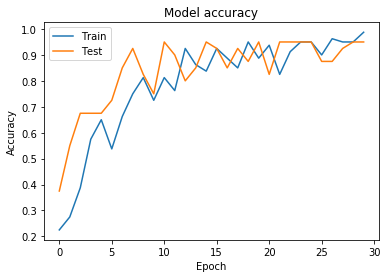

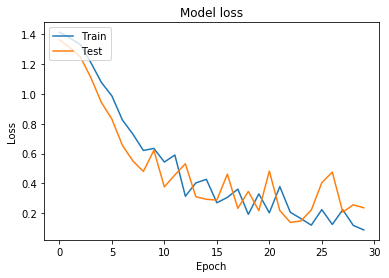

In [84]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [85]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_aed_restaurant_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [86]:
del model
model = models.load_model(filename)

## Confirmation

In [87]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(80, 96, 12, 1)

In [88]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [89]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [90]:
class_labels

['umai', 'others', 'mazui', 'oishii']

In [91]:
(activations[-1][:10]*100).astype(int)

array([[ 0,  0,  0, 99],
       [ 4,  0, 93,  1],
       [ 0,  0, 99,  0],
       [ 0,  0,  0, 99],
       [ 0,  0,  2, 97],
       [ 5,  0, 93,  0],
       [ 0,  0,  0, 99],
       [98,  1,  0,  0],
       [99,  0,  0,  0],
       [98,  1,  0,  0]])

In [92]:
test_labels[:10].astype(int)

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [93]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'umai'

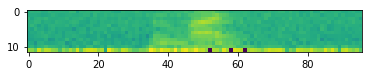

In [94]:
image_number = 8

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

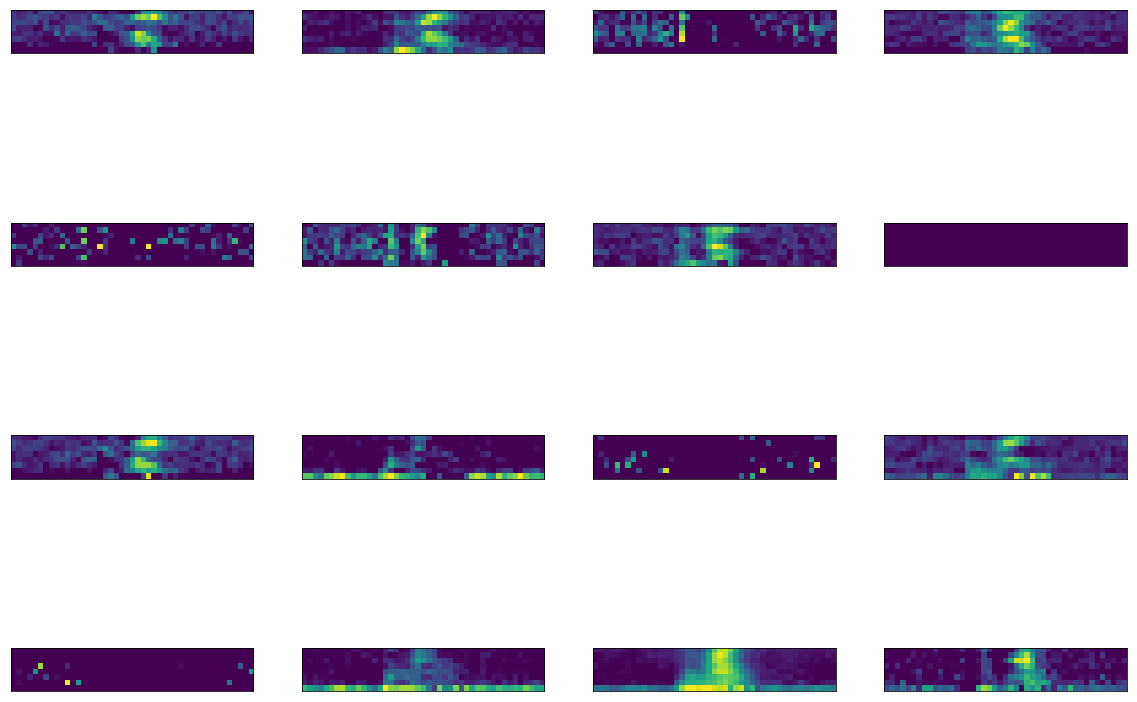

In [95]:
plot_layer(activations, image_number, 2)

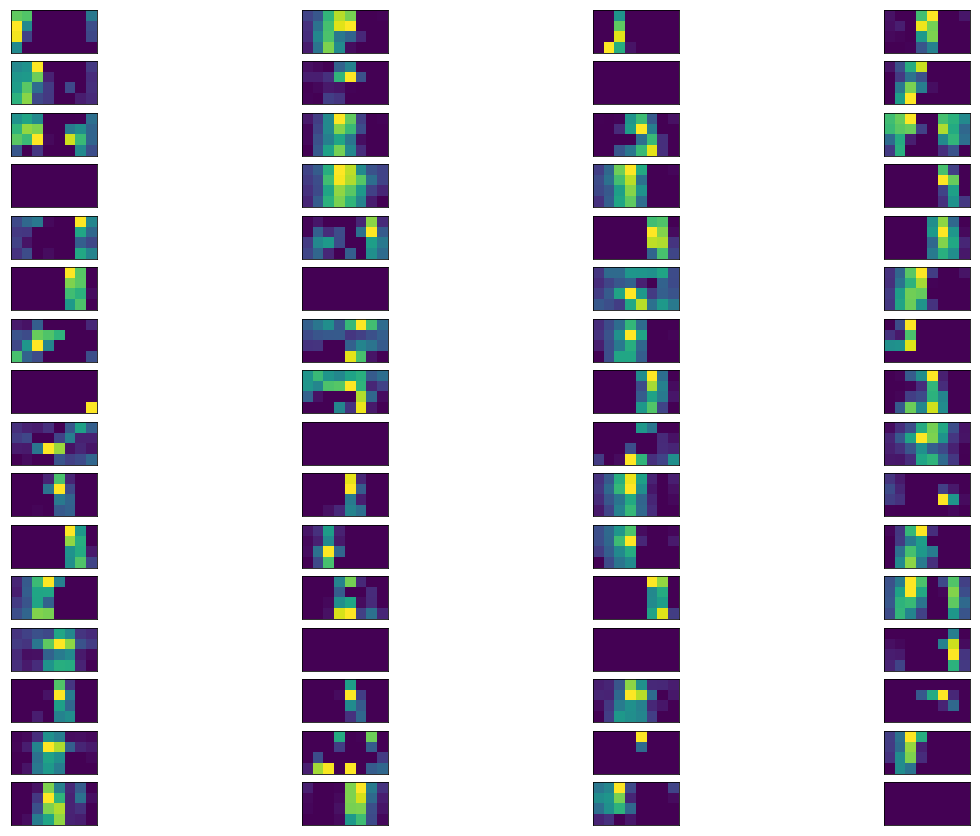

In [96]:
plot_layer(activations, image_number, 6)